# Исследрвание данных сервиса аренды самокатов GoFas</a>  

Мы получили данные части пользователей сервиса аренды самокатов GoFast: данные о пользователях нескольких городов и об их поездках. В данном проекте мы проанализируем данные и проверим некоторые гипотезы, которые могут помочь бизнесу вырасти. 

# Оглавление

[1 Шаг. Загрузка данных](#step1)  
 
[2 Шаг. Предобработка данных](#step2)  
 - [Проверка на пропуски](#step2.1)     
 - [Проверка на явные дубли](#step2.2)  
 - [Изменение типа данных](#step2.3)  
 - [Добавление новых столбцов](#step2.4)   
 
[3 Шаг. Исследовательский анализ данных](#step3)   
 - [Частота встречаемости городов](#step3.1)   
 - [Соотношение пользователей с подпиской и без подписки](#step3.2)   
 - [ Возраст пользователей](#step3.3)  
 - [ Расстояние, которое пользователь преодолел за одну поездку](#step3.4) 
 
[4 Шаг. Объединение данных](#step4)  
 - [ Объединение данных](#step4.1)  
 - [Создание новых датафреймов](#step4.2)   
 - [Расстояние и время поездок пользователей с подпиской](#step4.3)   
 - [Расстояние и время поездок пользователей без подписки](#step4.4)   
 
[5 Шаг. Подсчёт выручки](#step5)  

[6 Шаг Проверка гипотез](#step6)   
 - [Гипотеза 1: пользователи с подпиской тратят больше времени на сессию.](#step6.1)   
 - [Гипотеза 2. Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката.](#step6.2)   
 - [Гипотеза 3. Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. ](#step6.3)
 
[7 Шаг. Распределения ](#step7)   

[ Вывод ](#step8) 


Импортируем необходимые для работы библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
from math import factorial
from math import sqrt
from math import factorial
from scipy.stats import binom

 <a id='step1'></a>  

#### Шаг. Загрузка данных

Запишем датасет /datasets/users_go.csv в датафрейм **users**, посмотрим на его первые 5 строк и посмотрим информацию.<a id='intro'></a>

In [2]:
users = pd.read_csv('/datasets/users_go.csv', sep=',')
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


- `user_id`	уникальный идентификатор пользователя
- `name`	имя пользователя
- `age`	возраст
- `city`	город
- `subscription_type`	тип подписки (free, ultra)

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Запишем датасет /datasets/rides_go.csv в датафрейм **rides**, посмотрим на его первые 5 строк и посмотрим информацию.

In [4]:
rides = pd.read_csv('/datasets/rides_go.csv', sep=',')
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


- `user_id`	уникальный идентификатор пользователя
- `distance`	расстояние, которое пользователь проехал в текущей сессии (в метрах)
- `duration`	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- `date`	дата совершения поездки

In [5]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Запишем датасет /datasets/subscriptions_go.csv в датафрейм **subscriptions**, посмотрим на его первые 5 строк и посмотрим информацию.

In [6]:
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv', sep=',')
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


- `subscription_type`	тип подписки
- `minute_price`	стоимость одной минуты поездки по данной подписке
- `start_ride_price`	стоимость начала поездки
- `subscription_fee`	стоимость ежемесячного платежа

In [7]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


**Вывод**  
В нашем распоряжении 3 датафрейма:  
**users** с данными о пользователях, 1564 строк, с 5 столбцами.  
**rides** с данными о поездках пользователей, 18058 строк, с 4 колонками.  
**subscriptions** с данными о тарифах подписки, 2 строки, с 4 столбцами.

 <a id='step2'></a>

#### Шаг. Предобработка данных

<a id='step2.1'></a>

##### Проверка на пропуски 

Проверим данные на пропуски.

In [8]:
print('Пропуски в users:')
print(users.isna().sum())
print()
print('Пропуски в rides:')
print(rides.isna().sum())

Пропуски в users:
user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

Пропуски в rides:
user_id     0
distance    0
duration    0
date        0
dtype: int64


Пропусков нет.

<a id='step2.2'></a>

##### Проверка на явные дубли  

Проверим датафреймы на явные дубли.

In [9]:
print('Явных дублей в users:')
print(users.duplicated().sum())
print()
print('Явных дублей в rides:')
print(rides.duplicated().sum())


Явных дублей в users:
31

Явных дублей в rides:
0


В users обнаружились 31 явный дубль, удалим их.

In [10]:
users = users.drop_duplicates()

Проверим, удалились ли все дубли:

In [11]:
print('Явных дублей в users:')
print(users.duplicated().sum())
print()
print('Явных дублей в rides:')
print(rides.duplicated().sum())


Явных дублей в users:
0

Явных дублей в rides:
0


<a id='step2.3'></a>

##### Изменение типа данных 

In [12]:
rides['date'].head()

0    2021-01-01
1    2021-01-18
2    2021-04-20
3    2021-08-11
4    2021-08-28
Name: date, dtype: object

Приведем столбец `date` в **rides** к типу pandas datetime64

In [13]:
#форматируем столбец
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
#выводим первые 5 строк, чтобы удостовериться, что все выполнено верно
rides['date'].head()

0   2021-01-01
1   2021-01-18
2   2021-04-20
3   2021-08-11
4   2021-08-28
Name: date, dtype: datetime64[ns]

Посмотрим, за какой период у нас есть данные:

In [14]:
print('Самая ранняя дата в данных:', rides['date'].min())
print('Самая поздняя дата в данных:', rides['date'].max())

Самая ранняя дата в данных: 2021-01-01 00:00:00
Самая поздняя дата в данных: 2021-12-30 00:00:00


В нашем распоряжении данные с 1 января 2021 года по 30 декабря 2021 года.

<a id='step2.4'></a>

##### Добавление новых столбцов 

Создадим в **rides** столбец `month` со значениями номера месяца.

In [15]:
#Создаем столбец month
rides['month'] = rides['date'].dt.month
#выводим первые 5 строк, чтобы убедиться, что все сделано
rides[['date', 'month']].head()

,date,month
0,2021-01-01,1
1,2021-01-18,1
2,2021-04-20,4
3,2021-08-11,8
4,2021-08-28,8


**Вывод**  
Мы проверили данные на отсутствие пропусков, удалили явные дубли, изменили тип данных в столбце `date` датафрейма **rides** на тип datetime64 для удобства работы с ним, добавили к датафрейму **rides**  столбец `month` со значениями номера месяца.

 <a id='step3'></a>

#### Шаг. Исследовательский анализ данных

<a id='step3.1'></a>

##### Частота встречаемости городов  

Изучим в датафреме **users** столбец `city`.

In [16]:
users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

Визуализируем эти данные.

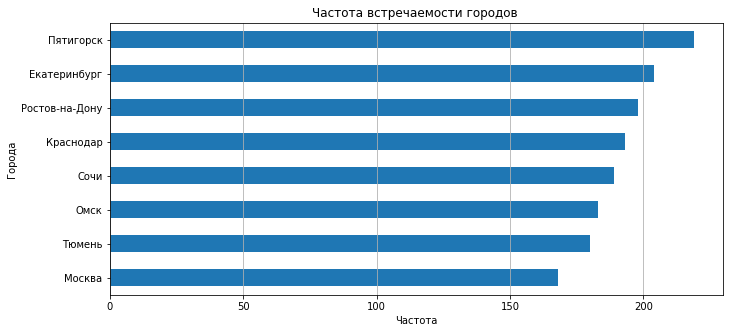

In [17]:
users['city'].value_counts().sort_values().plot.barh(figsize=(11, 5))
plt.grid(axis='x')
plt.title("Частота встречаемости городов ")
plt.xlabel("Частота")
plt.ylabel("Города");

Всего 8 городов, в каждом городе по 168-219 пользователей. Больше всего пользователей в Пятигорске, меньше всего - в Москве.

<a id='step3.2'></a>

##### Соотношение пользователей с подпиской и без подписки 

Изучим в датафреме **users** столбец `subscription_type`.

In [18]:
users['subscription_type'].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

Посчитаем в процентном соотношении%.

In [19]:
users['subscription_type'].value_counts() / len(users['subscription_type']) * 100

free     54.432855
ultra    45.567145
Name: subscription_type, dtype: float64

Визуализируем эти данные.

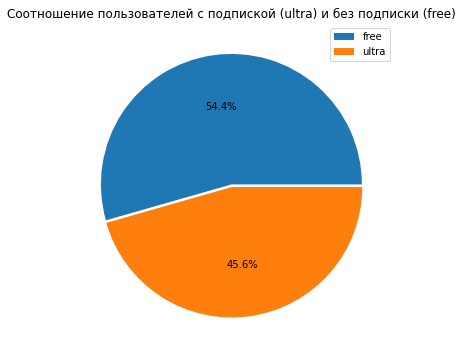

In [20]:
users['subscription_type'].value_counts().plot(kind="pie", 
                                               autopct='%1.1f%%',
                                               explode=[0.01, 0.01],
                                               legend=True, 
                                               title='Соотношение пользователей с подпиской (ultra) и без подписки (free)', 
                                               ylabel='', 
                                               labeldistance=None, 
                                               figsize=(6, 6))
plt.legend()
plt.show()

Пользователей без подписки, их около 54%, подписок типа "ultra" - около 46%.

<a id='step3.3'></a>

#####  Возраст пользователей 

Изучим в датафреме **users** столбец `age`.

Построим гистограмму.

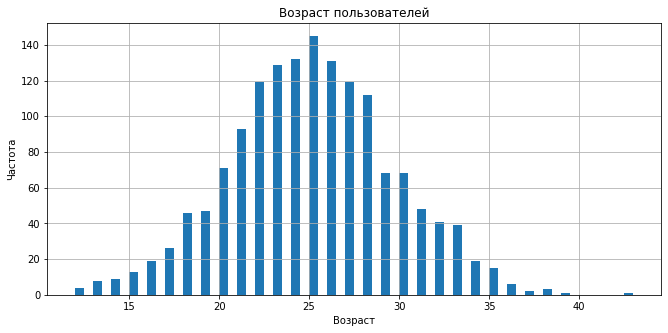

In [21]:
users['age'].hist(bins=62, figsize=(11, 5));
plt.title('Возраст пользователей')
plt.xlabel("Возраст")
plt.ylabel("Частота")
plt.show()


Изучим данные.

In [22]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Самому молодому пользователю 12 лет, а самому взрослому - 43. Средний возраст пользователей - 24,9 года, медианное значение (и самый распространенный возраст) - 25 лет.

<a id='step3.4'></a>

#####  Расстояние, которое пользователь преодолел за одну поездку 

Изучим столбец `distance` датафрема **rides**

In [23]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

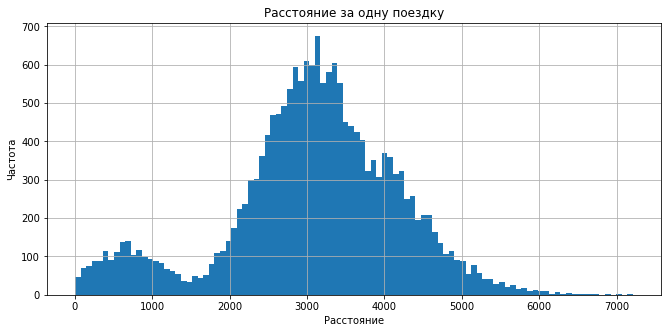

In [24]:
rides['distance'].hist(bins=100, figsize=(11, 5));
plt.title('Расстояние за одну поездку')
plt.xlabel("Расстояние")
plt.ylabel("Частота")
plt.show()

Мы видим, что минимальное расстояние за одну поездку - менее 1 метра, возможно, пользователи сталкиваются с какими-то проблемами (например, самокат не работает) и заканчивают почти сразу поездку. Максимальное расстояние одной поездки - более 7 км.  
На гистограмме мы видим, что есть два пика: один поменьше, около 700 м., и второй побольше - около 3100 м. Возможно, часть пользователей берет самокат просто попробовать прокатиться, или доехать до ближайшей остановки общественного транспорта, а вторая часть пользователей предпочитает более дальние поездки, например, во время прогулки по городу.  
Среднее расстояние поездки - 3071 м., медианное - 3134 м.

Проверим значения 1 и менее метров.

In [25]:
rides[rides['distance'] <=1].head()

,user_id,distance,duration,date,month
11555,1069,0.855683,10.001902,2021-01-31,1


Только один раз пользователь взял самокат и через 10 минут завершил поездку. Возможно, действительно были какие-то технические проблемы с самокатом.

<a id='step3.5'></a>

##### Продолжительность поездок 

Изучим столбец `duration` датафрема **rides**

In [26]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

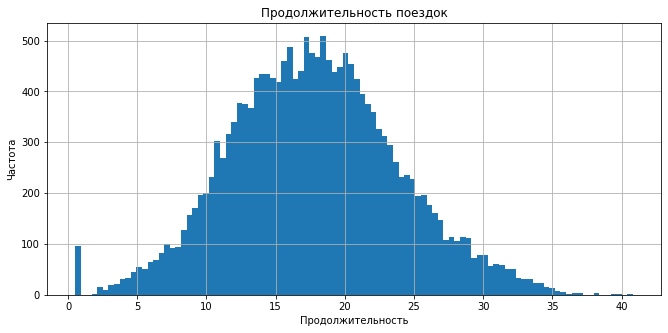

In [27]:
rides['duration'].hist(bins=100, figsize=(11, 5));
plt.title('Продолжительность поездок')
plt.xlabel("Продолжительность")
plt.ylabel("Частота")
plt.show()

Мы видим, что около 100 пользователей использовали самокат менее 1 минуты.

In [28]:
rides[rides['duration'] <= 1].head()

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2


Мы видим, что пользователь пользовался самокатом менее 1 минуты, но проехал более 4 км, это невозможно (получается, что самокат ехал со скоростью более 250 км/ч). Средняя скорость самоката 13-15 км/ч, а максимальная разрешенная - 25 км/ч. т.е. около 417 м/мин. Уберем из датафрема поездки, продолжительность которых менее 1 минуты, а расстояние - более 417 м. 

In [29]:
rides.loc[(rides['duration'] <= 1) & (rides['distance'] > 417), 'duration'] = None 
rides = rides.dropna(subset=['duration']) 

Взглянем еще раз на данные.

In [30]:
rides['duration'].describe()

count    17973.000000
mean        17.896480
std          5.975424
min          2.035632
25%         13.670439
50%         17.714122
75%         21.747016
max         40.823963
Name: duration, dtype: float64

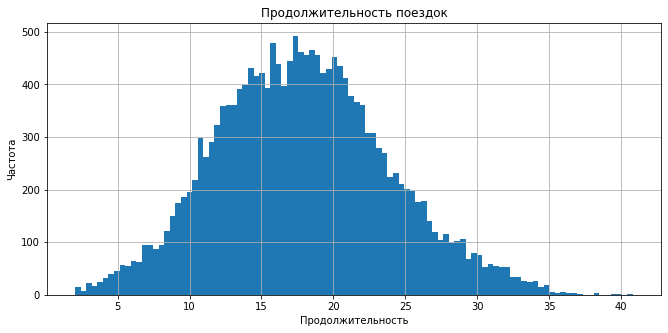

In [31]:
rides['duration'].hist(bins=100, figsize=(11, 5));
plt.title('Продолжительность поездок')
plt.xlabel("Продолжительность")
plt.ylabel("Частота")
plt.show()

Минимум пользователи берут самокат на 2 минуты, а максимум - на 40. Средня продолжительность времени поездки - 17,9 минут, а медианное значение - 17,7 мин.

**Вывод**  

Мы проверили исследовательский анализ данных. У нас данные по 8 городам, в каждом городе по 168-219 пользователей. Больше всего пользователей в Пятигорске, меньше всего - в Москве. Пользователей без подписки, их около 54%, подписок типа "ultra" - около 46%. Самому молодому пользователю 12 лет, а самому взрослому - 43. Средний возраст пользователей - 24,9 года, медианное значение (и самый распространенный возраст) - 25 лет. Среднее расстояние поездки - 3071 м., медианное - 3134 м. Минимум пользователи берут самокат на 2 минуты, а максимум - на 40. Средня продолжительность времени поездки - 17,9 минут, а медианное значение - 17,7 мин.


<a id='step4'> </a>

#### Шаг. Объединение данных 

<a id='step4.1'></a>

#####  Объединение данных 

Объединим датафремы **rides** и **users** по столбцу `user_id`. И к полученному датафрейму добавим данные из датафрема **subscriptions** по столбцу `subscription_type`

In [32]:
# объединяем датафрейм rides и users по столбцу user_id
df = rides.merge(users, on='user_id')
#объединяем датафрейм df и subscriptions по столбцу subscription_type
df = df.merge(subscriptions, on='subscription_type')
#
df.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


Посмотрим информацию по новому получившемуся датафрему.

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 17972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   distance           17973 non-null  float64       
 2   duration           17973 non-null  float64       
 3   date               17973 non-null  datetime64[ns]
 4   month              17973 non-null  int64         
 5   name               17973 non-null  object        
 6   age                17973 non-null  int64         
 7   city               17973 non-null  object        
 8   subscription_type  17973 non-null  object        
 9   minute_price       17973 non-null  int64         
 10  start_ride_price   17973 non-null  int64         
 11  subscription_fee   17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


И сравним размерности таблиц до и после объединения, чтобы удостовериться, что объединение прошло корректно.

In [34]:
print('Размерность таблицы до объедиения:')
print('rides')
print(rides.shape)
print('users')
print(users.shape)
print('subscriptions')
print(subscriptions.shape)
print('Размерность таблицы после объедиения:')
print(df.shape)

Размерность таблицы до объедиения:
rides
(17973, 5)
users
(1534, 5)
subscriptions
(2, 4)
Размерность таблицы после объедиения:
(17973, 12)


Строк, как в исходном датафрейме, столбцов 14-2=12, как и должно получиться.

Все строки заполнены, объединение прошло правильно.

<a id='step4.2'></a>

##### Создание новых датафреймов 

Создадим новый датафрейм **df_ultra**, в котором будут данные пользователей с подпиской ultra.

In [35]:
df_ultra = df.query('subscription_type == "ultra"')
df_ultra.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


Создадим новый датафрейм **df_free**, в котором будут данные пользователей без подписки.

In [36]:
df_free = df.query('subscription_type == "free"')
df_free.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0


 <a id='step4.3'></a>

##### Расстояние и время поездок пользователей с подпиской

Изучим столбец `distance` датафрейма **df_ultra**

In [37]:
df_ultra['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

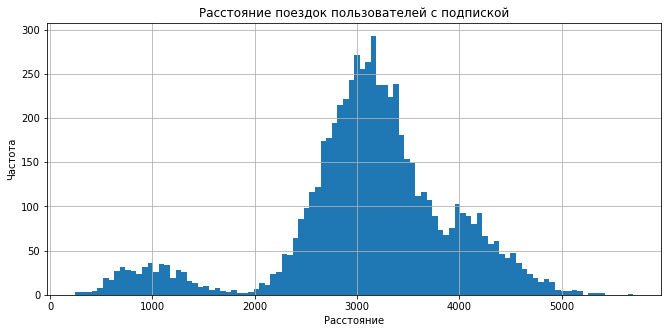

In [38]:
df_ultra['distance'].hist(bins=100, figsize=(11, 5));
plt.title('Расстояние поездок пользователей с подпиской')
plt.xlabel("Расстояние")
plt.ylabel("Частота")
plt.show()

Пользователи с подпиской в среднем проезжают на самокате 3115 метров за одну поездку, медианное значение 3149 м. На гистограмме мы видим 3 пика: около 1000 м., около 3000 м. и около 4000 м, что довольно удивительно, возможно, это связано с тем, что самокаты сервис устанавливает на таких расстояниях от ближайших важных точек (станций общественного транспорта, парков, ТЦ). Минимальное расстояние за одну сессию - 244 м, максимальное - 5700 м.

Изучим столбец `duration` датафрейма **df_ultra**

In [39]:
df_ultra['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

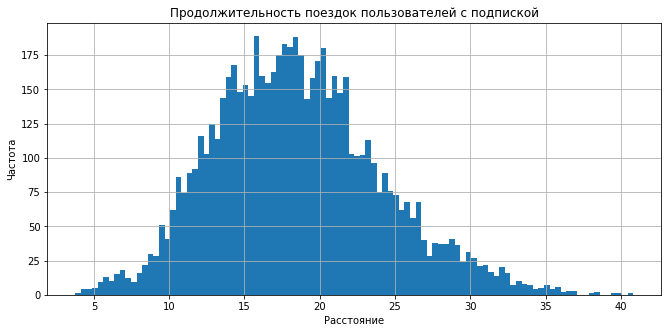

In [40]:
df_ultra['duration'].hist(bins=100, figsize=(11, 5));
plt.title('Продолжительность поездок пользователей с подпиской')
plt.xlabel("Расстояние")
plt.ylabel("Частота")
plt.show()

Пользователи с подпиской в среднем едут на самокате около 18,5 минут, медианное значение также около 18 мин. Самая короткая поездка - около 3,8 мин, самая продолжительная - около 40 мин.

<a id='step4.4'></a>

##### Расстояние и время поездок пользователей без подписки

Изучим столбец `distance` датафрейма **df_free**

In [41]:
df_free['distance'].describe()

count    11473.000000
mean      3028.374239
std       1235.541051
min          0.855683
25%       2360.878149
50%       3102.083025
75%       3883.979311
max       7066.003772
Name: distance, dtype: float64

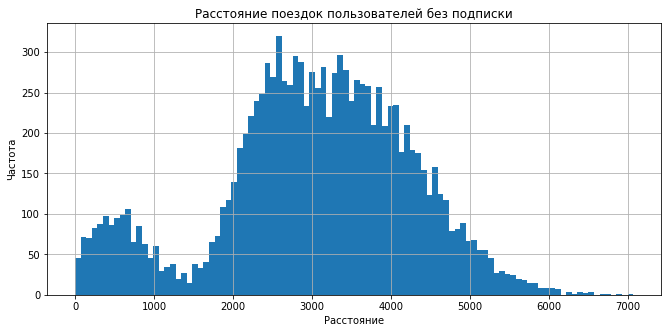

In [42]:
df_free['distance'].hist(bins=100, figsize=(11, 5));
plt.title('Расстояние поездок пользователей без подписки')
plt.xlabel("Расстояние")
plt.ylabel("Частота")
plt.show()

Пользователи без подписки в среднем проезжают на самокате 3028 метров за одну поездку, медианное значение 3102 м. На гистограмме мы видим 2 пика: около 500 м. и около 3000 м. и около 4000 м, что совпадает с пользователями с подпиской, но нет ярко выраженного пика около 4000 м. Минимальное расстояние за одну сессию - около 1 м, максимальное - 7066 м.

Изучим столбец `duration` датафрейма **df_free**

In [43]:
df_free['duration'].describe()

count    11473.000000
mean        17.530771
std          6.162609
min          2.035632
25%         13.085688
50%         17.383807
75%         21.638038
max         34.948498
Name: duration, dtype: float64

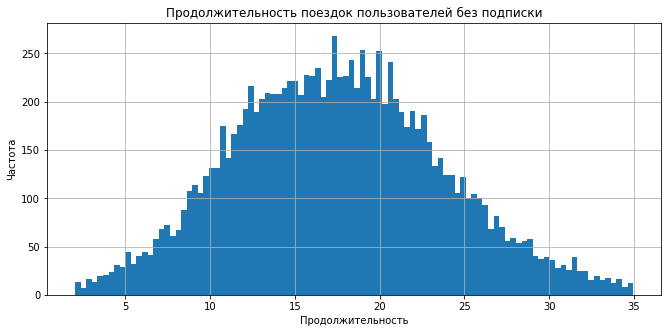

In [44]:
df_free['duration'].hist(bins=100, figsize=(11, 5));
plt.title('Продолжительность поездок пользователей без подписки')
plt.xlabel("Продолжительность")
plt.ylabel("Частота")
plt.show()

Пользователи без подписки в среднем едут на самокате около 17,5 минут, медианное значение также около 17 мин. Самая короткая поездка - около 2 мин, самая продолжительная - около 35 мин.

Для наглядности сравнения, посмотрим совместную гистограмму продолжительности поездок, для пользователей с и без пописки.

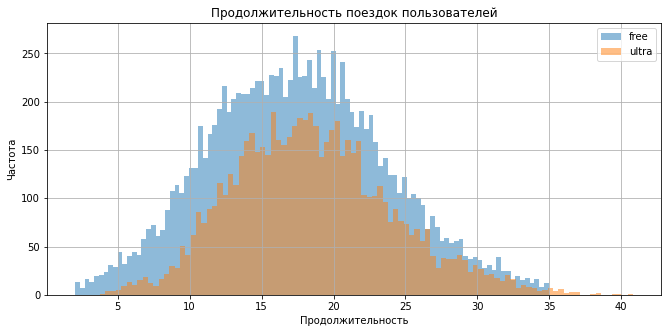

In [45]:
fig, ax = plt.subplots(figsize=(11, 5))
ax.hist(df_free['duration'], 100, alpha=0.5, label='free', )
ax.hist(df_ultra['duration'], 100, alpha=0.5, label='ultra',)
plt.title('Продолжительность поездок пользователей')
plt.xlabel('Продолжительность')
plt.ylabel('Частота')
plt.legend()
plt.grid()
plt.show()

Для наглядности сравнения, посмотрим совместную гистограмму расстояния поездок, для пользователей с и без пописки.

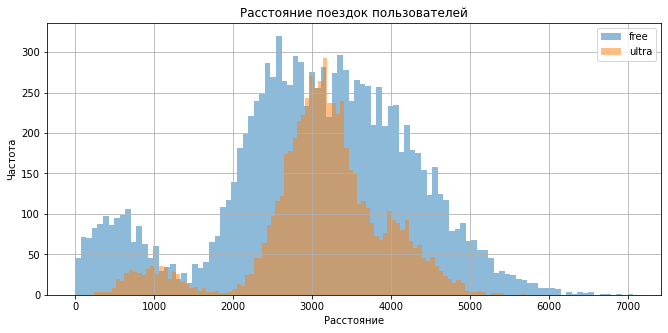

In [46]:
fig, ax = plt.subplots(figsize=(11, 5))
ax.hist(df_free['distance'], 100, alpha=0.5, label='free' )
ax.hist(df_ultra['distance'], 100, alpha=0.5, label='ultra')
plt.title('Расстояние поездок пользователей')
plt.xlabel('Расстояние')
plt.ylabel('Частота')
plt.legend()
plt.grid()
plt.show()

**Вывод**  
Мы создали 3 новых датафрейма:  
**df** - датафрейм, объединяющий в себе все 3 исходных датафрема (**rides, users, subscriprion**) на основе 
**rides**,           

**df_free** с данными пользователей без подписки,  
**df_ultra** с данными пользователей с подпиской.  
Изучили:  
расстояние поездок пользователей с подпиской: минимальное - 244 м., максимальное - 5700 м., среднее - 3115 м., медианое- 3149 м.,  
время сессий пользователей с подпиской: минимальное - 3,8 мин, максимальное - 40 мин., среднее - 18,5 мин, медианное - 18 мин.,  
расстояние поездок пользователей без подписки: минимальное - 1 м., максимальное - 7066 м., среднее - 3028 м., медианое- 3102 м.,  
время сессий пользователей без подписки: минимальное - 2 мин, максимальное - 35 мин., среднее - 17,5 мин, медианное - 17 мин.

<a id='step5'></a>

####  Шаг. Подсчёт выручки 

Для подсчета выручки посчитаем суммарное количество поездок, расстояние и времени сессий в месяц для каждого пользователя.

In [47]:
# огругляем значения в столбце duration значения в большую сторону
df['duration'] = np.ceil(df['duration'])
# сделаем сводную таблицу из df
df_pivot = df.pivot_table = pd.pivot_table(df,
                        #в качестве индексов используем ИД пользователя, месяц поездки и тип подписки
                       index=["user_id", 'month', 'subscription_type'],
                        # значения, которые будем группировать расстояние и продолжительность сессии
                       values=['distance', 'duration'],
                        #расстояние - подсчитываем количество и сумму в каждый месяц, продолжительность - только сумму
                       aggfunc={"distance": ['count', 'sum'], 'duration': 'sum'},
                        #если появятся пустые значения, то заполним их нулем
                       fill_value=0)
#переименовываем столбцы для более простой работы и читаемости таблицы
df_pivot = df_pivot.rename(columns={"distance":"", "duration":""})
df_pivot.columns = [t[0] if t[0] else t[1] for t in df_pivot.columns]
df_pivot.columns = ['rides', 'total_distance', 'total_duration']
#сбрасываем индекс
df_pivot = df_pivot.reset_index()
#выводим 5 первых строк
df_pivot.head()

,user_id,month,subscription_type,rides,total_distance,total_duration
0,1,1,ultra,2,7027.511294,42
1,1,4,ultra,1,754.159807,7
2,1,8,ultra,2,6723.470560,46
3,1,10,ultra,2,5809.911100,32
4,1,11,ultra,3,7003.499363,56


`user_id` - уникальный идентификатор пользователя,  
`month` - месяц,  
`subscription_type` - тип подписки,  
`rides` - количество поездок,  
`total_distance` - суммарное расстояние,  
`total_duration` - суммарное время.

Для простоты подсчета добавим в нашу таблицу тарифы, в зависимости от типа подписки

In [48]:
df_pivot = df_pivot.merge(subscriptions, on='subscription_type')
#
df_pivot.head()

,user_id,month,subscription_type,rides,total_distance,total_duration,minute_price,start_ride_price,subscription_fee
0,1,1,ultra,2,7027.511294,42,6,0,199
1,1,4,ultra,1,754.159807,7,6,0,199
2,1,8,ultra,2,6723.470560,46,6,0,199
3,1,10,ultra,2,5809.911100,32,6,0,199
4,1,11,ultra,3,7003.499363,56,6,0,199


Создаем столбец `revenue` с ежемесячной выручкой, которую считаем по формуле:  
(стоимость старта поездки × количество поездок) + (стоимость одной минуты поездки × общая продолжительность всех поездок в минутах) + стоимость подписки.

In [49]:
df_pivot['revenue'] = df_pivot['total_duration']*df_pivot['minute_price'] + df_pivot['rides']*df_pivot['start_ride_price'] + df_pivot['subscription_fee']
df_pivot.head(10)


,user_id,month,subscription_type,rides,total_distance,total_duration,minute_price,start_ride_price,subscription_fee,revenue
0,1,1,ultra,2,7027.511294,42,6,0,199,451
1,1,4,ultra,1,754.159807,7,6,0,199,241
2,1,8,ultra,2,6723.470560,46,6,0,199,475
3,1,10,ultra,2,5809.911100,32,6,0,199,391
4,1,11,ultra,3,7003.499363,56,6,0,199,535
5,1,12,ultra,2,6751.629942,28,6,0,199,367
6,2,3,ultra,3,10187.723006,63,6,0,199,577
7,2,4,ultra,2,6164.381824,40,6,0,199,439
8,2,6,ultra,1,3255.338202,14,6,0,199,283
9,2,7,ultra,2,6780.722964,48,6,0,199,487


Уберем из датафрейма столбцы с тарифной информацией подписок, т.к. она нам больше не нужна.

In [50]:
df_pivot = df_pivot[['user_id', 'month', 'subscription_type',  'rides', 'total_distance', 'total_duration', 'revenue']]
df_pivot.head()

,user_id,month,subscription_type,rides,total_distance,total_duration,revenue
0,1,1,ultra,2,7027.511294,42,451
1,1,4,ultra,1,754.159807,7,241
2,1,8,ultra,2,6723.470560,46,475
3,1,10,ultra,2,5809.911100,32,391
4,1,11,ultra,3,7003.499363,56,535


`user_id` - уникальный идентификатор пользователя,  
`month` - месяц,  
`subscription_type` - тип подписки,   
`rides` - количество поездок,  
`total_distance` - суммарное расстояние,  
`total_duration` - суммарное время,  
`revenue` - выручка.


Посмотрим на данные по выручке.

In [51]:
df_pivot['revenue'].describe()

count    11300.000000
mean       342.754956
std        153.317314
min         74.000000
25%        234.000000
50%        319.000000
75%        415.000000
max       1444.000000
Name: revenue, dtype: float64

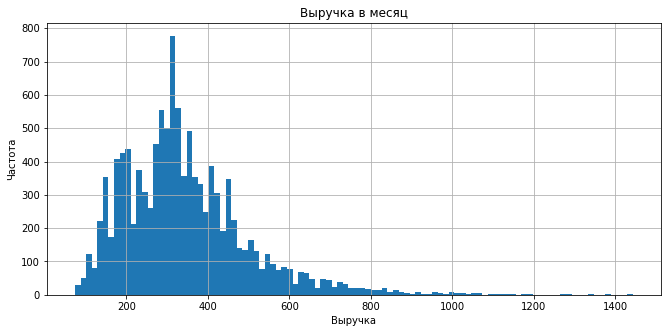

In [52]:
df_pivot['revenue'].hist(bins=100, figsize=(11, 5));
plt.title('Выручка в месяц')
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.show()

Минимальная выручка в месяц - 74, максимальная - 1444. Средняя выручка в месяц около 343, медианная - около 319.

**Вывод**  
Мы подсчитали выручку в месяц: минимальноя - 74, максимальная - 1444, средняя - 343, медианная - 319.

<a id='step6'></a>

####  Шаг Проверка гипотез 

<a id='step6.1'></a>

#####  Гипотеза 1: пользователи с подпиской тратят больше времени на сессию. 

Выидвенем нулевую гипотезу, что среднее время сессий у пользователей с подпиской равно среднему времени сессий у пользователей без подписки. Альтернативная гипотеза - пользователи с подпиской тратят больше времени на одну сессию. Проверим ее методом для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам

In [53]:
# задаём уровень значимости
alpha = 0.05
# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу "больше"
results = st.ttest_ind(df_ultra['duration'], df_free['duration'], equal_var=False, alternative='greater')

# проверяем p-value
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 
print('Среднее время сессии для пользователей с подпиской:', df_ultra['duration'].mean())
print('Среднее время сессии для пользователей без подписки:', df_free['duration'].mean())

p-значение: 1.6162210195311063e-29
Отвергаем нулевую гипотезу
Среднее время сессии для пользователей с подпиской: 18.54198516280583
Среднее время сессии для пользователей без подписки: 17.530771268800226


Мы можем отвергнуть нулевую гипотезу, есть основания говорить, что пользователи с подпиской тратят больше времени на сессию.

 <a id='step6.2'></a>

##### Гипотеза 2. Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката.

В данной гипотезе мы проверям, можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?  
Нулевая гипотеза - пользователи с подпиской за одну сессию проезжают в среднем 3130 метров.  
Альтернативная гипотеза - пользователи с подпиской за одну сессию проезжают больше 3130 метров.

In [54]:
distance_value = 3130  ## предполагаемое значение среднего расстояния, которое пользователь с подпиской проезжает за одну сессию

alpha = 0.05 # уровень статистической значимости

results = st.ttest_1samp(
    df_ultra['distance'], 
    distance_value,
    alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу


Мы не отвергаем нулевую гипотезу. Возможно пользователи с подпиской проезжают 3130 метров за одну сессию.

<a id='step6.3'></a>

##### Гипотеза 3. Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

Нулевая гепотеза - помесячная вырочка от пользователей с подпиской по месяцам равна  выручке от пользователей без подписки.  
Альтернативная гипотеза - помесячная вырочка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

In [55]:
# задаём уровень значимости
alpha = 0.05
# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу "больше"
results = st.ttest_ind(df_pivot.query('subscription_type == "ultra"')['revenue'], df_pivot.query('subscription_type == "free"')['revenue'], equal_var=False, alternative='greater')

# проверяем p-value
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

print('Средняя помесячная выручка пользователей с подпиской:', df_pivot.query('subscription_type == "ultra"')['revenue'].mean())
print('Средняя помесячная выручка пользователей без подписки:', df_pivot.query('subscription_type == "free"')['revenue'].mean())
    

p-значение: 2.4970242872858465e-38
Отвергаем нулевую гипотезу
Средняя помесячная выручка пользователей с подпиской: 362.7921906022502
Средняя помесячная выручка пользователей без подписки: 329.3326437121324


Мы можем отвергнуть нулевую гипотезу, есть основания говорить, что выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

<a id='step6.4'></a>

##### Гипотеза 4. 

**Вопрос**  
Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

**Ответ**  
Нам нужно было бы проверить гипотезу о равенстве средних для зависимых (парных) выборок.  
Выборки в этом случае будут зависимыми, иначе — парными. Парная выборка означает, что некоторая переменная измеряется дважды для одних и тех же объектов. В нашем примере это пара измерений для каждого пользователя — до и после обновления сервиса.  
Оба набора должны быть одинаковыми по размеру: каждое измерение должно быть проведено до и после изменения.
Подразумевается, что порядок объектов, для которых сделаны измерения, в обоих массивах тоже одинаковый:  
k-е по порядку число в первом наборе и  
k-е число во втором наборе — это измерения для одного и того же объекта до и после изменения.
Проверить гипотезу можно удет методом `scipy.stats.ttest_rel()`

**Вывод**  
Мы проверили 4 гипотезы:
 - есть основания говорить, что пользователи с подпиской тратят больше времени на сессию,  
 - возможно пользователи с подпиской проезжают 3130 метров за одну сессию,  
 - основания говорить, что выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки,  
 - для проверки гипотезы о снижении количества обращейний в техподдержку после обновления сервиса необходимо проверить гипотезу о равенстве среднийх зависимых выборок методом `scipy.stats.ttest_rel()`.

 

<a id='step8'></a>

#### Вывод  

Мы провели предобаботку данных:
- Очистили данные от явных дублей.
- Изменили тип данных в столбце с датой сессии, сделали типом datetime64.
- Добавили новы столбец `month` - с указанием месяца сессии.
- Очистили данные от ошибочных данных, так, например, встречались данные, где пользователи менее чем за минуту проезжали тысячи метров.  
  
Мы провели исследование данных:
- В данных информация из 8 городов, в каждом городе по 168-219 пользователей. Больше всего пользователей в Пятигорске, меньше всего - в Москве.
- Пользователей без подписки, их около 54%, подписок типа "ultra" - около 46%.
- Самому молодому пользователю 12 лет, а самому взрослому - 43. Средний возраст пользователей - 24,9 года, медианное значение (и самый распространенный возраст) - 25 лет.
- Минимальное расстояние за одну поездку - менее 1 метра, возможно, пользователи сталкиваются с какими-то проблемами (например, самокат не работает). Максимальное расстояние одной поездки - более 7 км.  Среднее расстояние поездки - 3071 м., медианное - 3134 м.
- Минимум пользователи берут самокат на 2 минуты, а максимум - на 40. Средня продолжительность времени поездки - 17,9 минут, а медианное значение - 17,7 мин.
- Пользователи с подпиской в среднем проезжают на самокате 3115 метров за одну поездку, медианное значение 3149 м. На гистограмме мы видим 3 пика: около 1000 м., около 3000 м. и около 4000 м, что довольно удивительно, возможно, это связано с тем, что самокаты сервис устанавливает на таких расстояниях от ближайших важных точек (станций общественного транспорта, парков, ТЦ). Минимальное расстояние за одну сессию - 244 м, максимальное - 5700 м.
- Пользователи без подписки в среднем проезжают на самокате 3028 метров за одну поездку, медианное значение 3102 м. На гистограмме мы видим 2 пика: около 500 м. и около 3000 м. и около 4000 м, что совпадает с пользователями с подпиской, но нет ярко выраженного пика около 4000 м. Минимальное расстояние за одну сессию - около 1 м, максимальное - 7066 м.
- Пользователи с подпиской в среднем едут на самокате около 18,5 минут, медианное значение также около 18 мин. Самая короткая поездка - около 3,8 мин, самая продолжительная - около 40 мин.
- Пользователи без подписки в среднем едут на самокате около 17,5 минут, медианное значение также около 17 мин. Самая короткая поездка - около 2 мин, самая продолжительная - около 35 мин.
- Была посчитана выручка в месяц: минимальная выручка в месяц - 74, максимальная - 1444, средняя выручка в месяц около 343, медианная - около 319.
Было проверено несколько гипотез:
- Есть основания говорить, что пользователи с подпиской тратят больше времени на сессию, чем пользователи без подписки.
- Возможно пользователи с подпиской проезжают 3130 метров за одну сессию.
- Есть основания говорить, что выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Рекомендации:
- Поправить точность измерения дистанции - сейчас данные о дистанции сохраняются с точностью до микрометра, нет необходимости такой точности.
- Данные по продолжительности можно сохранять с округлением до большего целого значения, т.к. Плата взымается поминутно.
